# 최종 집 값 예측

### 데이터 가져오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 시각화 라이브러리
from sklearn.preprocessing import LabelEncoder #인코딩 도구
from scipy.stats import skew, norm

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

## 0. 데이터 분석

### 수치,범주 나누기

In [3]:
numerical_feats = train.dtypes[train.dtypes != "object"].index 
print("Number of Numerical features: ", len(numerical_feats)) 
categorical_feats = train.dtypes[train.dtypes == "object"].index 
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


In [4]:
print(train[numerical_feats].columns) # 수치형
print("*"*80) 
print(train[categorical_feats].columns) # 범주형

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
********************************************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual'

## 1.이상치 제거

In [5]:
from collections import Counter 

In [6]:
def detect_outliers(df, n, features): 
    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25) 
        Q3 = np.percentile(df[col], 75) 
        IQR = Q3 - Q1 
        outlier_step = 1.5 * IQR 
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index 
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices) 
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n) 
    
    return multiple_outliers 
Outliers_to_drop = detect_outliers(train, 2, ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 
                                                 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
                                                 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                                                 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
                                                 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                                                 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                                                 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 
                                                 'YrSold'])

In [7]:
train = train.drop(Outliers_to_drop, axis= 0).reset_index(drop = True)
train.shape

(1666, 81)

## 2. 정답컬럼 정규화

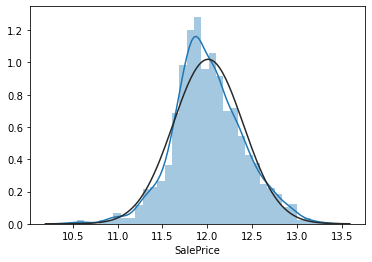

<Figure size 432x288 with 0 Axes>

In [8]:
#정답 컬럼 정규화, y에 저장
train.SalePrice = np.log1p(train.SalePrice)
y_train = train.SalePrice

#시각화하여 확인
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()

#정답컬럼 드랍
train.drop('SalePrice', axis=1, inplace=True)

#### train, test 합치기

In [9]:
# 컬럼 확인 출력
print(train.shape)
print(test.shape)
print(y_train.shape)

(1666, 80)
(1168, 80)
(1666,)


In [10]:
# train, test 합치기
combined = pd.concat([train,test],ignore_index=True)
combined

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2,20,RL,NaN,10530,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
1,3,20,RL,88.0,12803,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
2,4,60,FV,114.0,8314,Pave,Pave,IR1,Lvl,AllPub,...,110,0,NaN,GdPrv,NaN,0,11,2006,WD,Normal
3,5,20,RL,78.0,10335,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,7,2006,WD,Normal
4,6,90,RL,55.0,12640,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,2915,20,RL,70.0,8402,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2007,New,Partial
2830,2916,50,RM,50.0,9140,Pave,NaN,Reg,HLS,AllPub,...,200,0,NaN,MnPrv,NaN,0,4,2010,COD,Normal
2831,2917,20,RL,NaN,8050,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,NaN,0,5,2010,WD,Normal
2832,2918,60,RL,NaN,8637,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2007,WD,Abnorml


## 3. 결측치 확인, 채우기
- 결측치가 NA값으로 의미가 있는 경우가 많으므로 일단 다 가져가자

In [11]:
#누락데이터 확인
total = combined.isnull().sum().sort_values(ascending=False)
percent = (combined.isnull().sum()/combined.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total > 0].head(-1)

,Total,Percent
PoolQC,2827,0.997530
MiscFeature,2741,0.967184
Alley,2650,0.935074
Fence,2276,0.803105
FireplaceQu,1381,0.487297
LotFrontage,470,0.165843
GarageCond,142,0.050106
GarageQual,142,0.050106
GarageYrBlt,142,0.050106
GarageFinish,142,0.050106


In [12]:
#결측치 채우기
# 정의에 의해 누락 데이터가 '누락'을 의미하는게 아닌 아닌 '없음'을 의미(ex. 수영장 없음)하는 경우0과 같은 데이터로 대체 해준다.
# 데이터 정의에 써져있다.
combined['GarageArea'].fillna(0, inplace=True)
combined['GarageQual'].fillna('No', inplace=True)
combined['GarageCond'].fillna('No', inplace=True)
combined['Fence'].fillna('No', inplace=True)
combined['MiscFeature'].fillna('No', inplace=True)
combined['BsmtQual'].fillna('No', inplace=True)
combined['BsmtCond'].fillna('No', inplace=True)
combined['BsmtExposure'].fillna('No', inplace=True)
combined['BsmtFinType1'].fillna('No', inplace=True)
combined['BsmtFinSF1'].fillna(0, inplace=True) # 평균값 사용
combined['BsmtFinType2'].fillna('No', inplace=True)
combined['BsmtFinSF2'].fillna(0, inplace=True) # 수치형 - 연속형데이터 :mean 45.475429
combined['BsmtUnfSF'].fillna(0, inplace=True) # 중간값(50%)사용, 461.000000
combined['TotalBsmtSF'].fillna(0, inplace=True) # 중간값(50%)사용, 980.000000
combined['Electrical'].fillna('SBrkr', inplace=True)  # 최빈값(top)
combined['BsmtFullBath'].fillna(0, inplace=True) # mean
combined['BsmtHalfBath'].fillna(0, inplace=True) #mean
combined['Functional'].fillna('Typ', inplace=True)
combined['FireplaceQu'].fillna('No', inplace=True)
combined['GarageType'].fillna('No', inplace=True)
combined['GarageYrBlt'].fillna(0, inplace=True)
combined['GarageFinish'].fillna('No', inplace=True)
combined['GarageCars'].fillna(0, inplace=True)
combined['MSZoning'].fillna('RL', inplace=True)
combined['LotFrontage'].fillna(0, inplace=True)
combined['Alley'].fillna('None', inplace=True)
combined['PoolQC'].fillna('No', inplace=True)
combined['Utilities'].fillna('AllPub', inplace=True)
combined['MasVnrType'].fillna('None', inplace=True)
combined['MasVnrArea'].fillna(0, inplace=True)
combined['SaleType'].fillna('WD', inplace=True) # 최빈값 사용
combined['Exterior1st'].fillna('VinylSd', inplace=True)
combined['Exterior2nd'].fillna('VinylSd', inplace=True)
combined['KitchenQual'].fillna('TA', inplace=True)

In [13]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2834 non-null   int64  
 1   MSSubClass     2834 non-null   int64  
 2   MSZoning       2834 non-null   object 
 3   LotFrontage    2834 non-null   float64
 4   LotArea        2834 non-null   int64  
 5   Street         2834 non-null   object 
 6   Alley          2834 non-null   object 
 7   LotShape       2834 non-null   object 
 8   LandContour    2834 non-null   object 
 9   Utilities      2834 non-null   object 
 10  LotConfig      2834 non-null   object 
 11  LandSlope      2834 non-null   object 
 12  Neighborhood   2834 non-null   object 
 13  Condition1     2834 non-null   object 
 14  Condition2     2834 non-null   object 
 15  BldgType       2834 non-null   object 
 16  HouseStyle     2834 non-null   object 
 17  OverallQual    2834 non-null   int64  
 18  OverallC

## 4. 특성공학

#### 수치, 범주 변환

In [14]:
def cat_to_num(df):
    # 숫자 데이터가 범주형 데이터로 기록되어있는 경우 숫자형 데이터로 변경해준다.
    df = df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })
    
    # 범주형 데이터가 수치적 의미를 갖고있는 경우 숫자형 데이터로 변경해준다.
    df = df.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )
    return df

combined = cat_to_num(combined)

#### 유무 파악 컬럼 변환

In [15]:
def make_has_feature(df):
    # 있는지 없는지 정도만 판단해도 충분히 좋은 Feature가 된다.
    df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    return df

combined = make_has_feature(combined)

#### 새로운 컬럼 추가

In [16]:
def simplify_feature(df) :
    # 1. 이미 있는 feature를 단순화시키기
    df["SimplOverallQual"] = df.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                    4 : 2, 5 : 2, 6 : 2, # average
                                                    7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                    })
    df["SimplOverallCond"] = df.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                    4 : 2, 5 : 2, 6 : 2, # average
                                                    7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                    })
    df["SimplPoolQC"] = df.PoolQC.replace({1 : 1, 2 : 1, # average
                                            3 : 2, 4 : 2 # good
                                            })
    df["SimplGarageCond"] = df.GarageCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                        })
    df["SimplGarageQual"] = df.GarageQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                        })
    df["SimplFireplaceQu"] = df.FireplaceQu.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                          })
    df["SimplFireplaceQu"] = df.FireplaceQu.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                          })
    df["SimplFunctional"] = df.Functional.replace({1 : 1, 2 : 1, # bad
                                                   3 : 2, 4 : 2, # major
                                                   5 : 3, 6 : 3, 7 : 3, # minor
                                                   8 : 4 # typical
                                                        })
    df["SimplKitchenQual"] = df.KitchenQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                          })
    df["SimplHeatingQC"] = df.HeatingQC.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                      })
    df["SimplBsmtFinType1"] = df.BsmtFinType1.replace({1 : 1, # unfinished
                                                       2 : 1, 3 : 1, # rec room
                                                       4 : 2, 5 : 2, 6 : 2 # living quarters
                                                       })
    df["SimplBsmtFinType2"] = df.BsmtFinType2.replace({1 : 1, # unfinished
                                                       2 : 1, 3 : 1, # rec room
                                                       4 : 2, 5 : 2, 6 : 2 # living quarters
                                                       })
    df["SimplBsmtCond"] = df.BsmtCond.replace({1 : 1, # bad
                                               2 : 1, 3 : 1, # average
                                               4 : 2, 5 : 2 # good
                                               })
    df["SimplBsmtQual"] = df.BsmtQual.replace({1 : 1, # bad
                                               2 : 1, 3 : 1, # average
                                               4 : 2, 5 : 2 # good
                                               })
    df["SimplExterCond"] = df.ExterCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                 })
    df["SimplExterQual"] = df.ExterQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                 })
    return df

def combine_feature(df) :
    # 2* 기존 feature들을 조합시키기
    # Overall quality of the house
    df["OverallGrade"] = df["OverallQual"] * df["OverallCond"]
    # Overall quality of the garage
    df["GarageGrade"] = df["GarageQual"] * df["GarageCond"]
    # Overall quality of the exterior
    df["ExterGrade"] = df["ExterQual"] * df["ExterCond"]
    # Overall kitchen score
    df["KitchenScore"] = df["KitchenAbvGr"] * df["KitchenQual"]
    # Overall fireplace score
    df["FireplaceScore"] = df["Fireplaces"] * df["FireplaceQu"]
    # Overall garage score
    df["GarageScore"] = df["GarageArea"] * df["GarageQual"]
    # Overall pool score
    df["PoolScore"] = df["PoolArea"] * df["PoolQC"]
    # Simplified overall quality of the house
    df["SimplOverallGrade"] = df["SimplOverallQual"] * df["SimplOverallCond"]
    # Simplified overall quality of the exterior
    df["SimplExterGrade"] = df["SimplExterQual"] * df["SimplExterCond"]
    # Simplified overall pool score
    df["SimplPoolScore"] = df["PoolArea"] * df["SimplPoolQC"]
    # Simplified overall garage score
    df["SimplGarageScore"] = df["GarageArea"] * df["SimplGarageQual"]
    # Simplified overall fireplace score
    df["SimplFireplaceScore"] = df["Fireplaces"] * df["SimplFireplaceQu"]
    # Simplified overall kitchen score
    df["SimplKitchenScore"] = df["KitchenAbvGr"] * df["SimplKitchenQual"]
    # Total number of bathrooms
    df["TotalBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + \
    df["FullBath"] + (0.5 * df["HalfBath"])
    # Total SF for house (incl. basement)
    df["AllSF"] = df["GrLivArea"] + df["TotalBsmtSF"]
    # Total SF for 1st + 2nd floors
    df["AllFlrsSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
    # Total SF for porch
    df["AllPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + \
    df["3SsnPorch"] + df["ScreenPorch"]
    # Has masonry veneer or not
    df["HasMasVnr"] = df.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1,  "Stone" : 1, "None" : 0})
    # House completed before sale or not
    df["BoughtOffPlan"] = df.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
    
    #추가
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF']  + df['2ndFlrSF']
    df['YrBltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']
    df['Total_sqr_footage'] = df['BsmtFinSF1']  + df['BsmtFinSF2'] + df['1stFlrSF']  + df['2ndFlrSF']
    
    
    
    return df

combined = simplify_feature(combined)

#### skew높은 순으로 졍규화

## 5. 컬럼 다듬기
- 닞은 상관관계, 다공성 데이터(연관되어 필요 없는 컬럼), 불필요한 범주형
- 구글링 참고

#### 불필요한 컬럼 지우기(낮은 상관관계)

In [17]:
combined.drop(['Id', 'ExterCond', 'BsmtFinType2', 'PoolQC', 'SimplPoolQC', 'PoolArea', 'haspool', 'YrSold',
           'MiscVal', 'BsmtFinSF2', 'BsmtHalfBath'], axis=1, inplace=True)

#### 범주형 컬럼 다듬기

In [18]:
# 가공을 위한 범주형 확인
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         2834 non-null   object 
 1   MSZoning           2834 non-null   object 
 2   LotFrontage        2834 non-null   float64
 3   LotArea            2834 non-null   int64  
 4   Street             2834 non-null   int64  
 5   Alley              2834 non-null   object 
 6   LotShape           2834 non-null   int64  
 7   LandContour        2834 non-null   object 
 8   Utilities          2834 non-null   int64  
 9   LotConfig          2834 non-null   object 
 10  LandSlope          2834 non-null   int64  
 11  Neighborhood       2834 non-null   object 
 12  Condition1         2834 non-null   object 
 13  Condition2         2834 non-null   object 
 14  BldgType           2834 non-null   object 
 15  HouseStyle         2834 non-null   object 
 16  OverallQual        2834 

In [19]:
#Null값 확인
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 89 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         2834 non-null   object 
 1   MSZoning           2834 non-null   object 
 2   LotFrontage        2834 non-null   float64
 3   LotArea            2834 non-null   int64  
 4   Street             2834 non-null   int64  
 5   Alley              2834 non-null   object 
 6   LotShape           2834 non-null   int64  
 7   LandContour        2834 non-null   object 
 8   Utilities          2834 non-null   int64  
 9   LotConfig          2834 non-null   object 
 10  LandSlope          2834 non-null   int64  
 11  Neighborhood       2834 non-null   object 
 12  Condition1         2834 non-null   object 
 13  Condition2         2834 non-null   object 
 14  BldgType           2834 non-null   object 
 15  HouseStyle         2834 non-null   object 
 16  OverallQual        2834 

In [20]:
combined.isnull().values.any()

False

## 6. 정규화

In [21]:
numeric_feats = combined.dtypes[combined.dtypes != "object"].index

# 수치형 데이터에서 skewness 체크
skewed_feats = combined[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
LowQualFinSF,15.167081
LotArea,13.998301
3SsnPorch,11.654862
KitchenAbvGr,4.567313
EnclosedPorch,4.150973
ScreenPorch,3.996926
MasVnrArea,2.600352
SimplExterCond,2.599077
OpenPorchSF,2.288539
WoodDeckSF,1.746936


In [22]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    combined[feat] = boxcox1p(combined[feat], lam)

There are 63 skewed numerical features to Box Cox transform


## 7. 인코딩

#### 원핫인코딩

In [23]:
#원핫: RoofStyle, RoofMatl, Fence, MiscFeature, MoSold, Exterior2nd, MSSubClass

In [24]:
#원핫인코딩
categorical_feature = ['RoofStyle','RoofMatl','Fence','MiscFeature','MoSold','Exterior2nd','MSSubClass',
                      'Alley','MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
                      'Exterior1st','MasVnrType','Foundation','Heating','CentralAir','Electrical','GarageType','GarageFinish','SaleType','SaleCondition']

In [25]:
one_hot = pd.get_dummies(combined[categorical_feature])
one_hot

,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2830,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2831,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2832,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [26]:
# 원핫인코딩을 진행한 문자열 데이터 삭제
combined.drop(categorical_feature,axis=1,inplace=True)

In [27]:
# 원핫인코딩한 숫자열 데이터를 추가
combined = pd.concat([combined,one_hot], axis=1) # 가로로 붙이는 경우 axis=1
combined

,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.000000,20.080586,1.194318,1.540963,1.820334,1.540963,2.259674,2.055642,14.137234,14.137234,...,0,0,0,1,0,0,0,0,1,0
1,6.404587,20.876292,1.194318,1.540963,1.820334,1.540963,2.440268,2.055642,14.185966,14.185966,...,0,0,0,1,0,0,0,0,1,0
2,6.916887,19.149281,1.194318,1.540963,1.820334,1.540963,2.440268,2.055642,14.178149,14.179714,...,0,0,0,1,0,0,0,0,1,0
3,6.172972,20.005704,1.194318,1.540963,1.820334,1.540963,2.055642,2.259674,14.132484,14.171884,...,0,0,0,1,0,0,0,0,1,0
4,5.527074,20.823410,1.194318,1.540963,1.820334,1.540963,2.259674,2.055642,14.145138,14.145138,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,5.968981,19.190081,1.194318,1.820334,1.820334,1.540963,2.055642,2.055642,14.193765,14.193765,...,0,1,0,0,0,0,0,0,0,1
2830,5.357203,19.518648,1.194318,1.820334,1.820334,1.540963,2.259674,2.055642,14.057246,14.143559,...,0,0,0,0,0,0,0,0,1,0
2831,0.000000,19.024641,1.194318,1.540963,1.820334,1.540963,2.055642,2.055642,14.118196,14.118196,...,0,0,0,1,0,0,0,0,1,0
2832,0.000000,19.297281,1.194318,1.540963,1.820334,1.540963,2.259674,2.055642,14.181278,14.182841,...,0,0,0,1,1,0,0,0,0,0


In [28]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Columns: 265 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(63), uint8(202)
memory usage: 1.9 MB


In [29]:
# 다시 train과 test 데이터 나눠주기
X_train = combined.iloc[:1666]
X_test = combined.iloc[1666:]

In [30]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape) #train 정답 컬럼

(1666, 265)
(1168, 265)
(1666,)


## 8.모델링

In [31]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [32]:
# 스케일러를 사용해주어야 오버플로우나 언더플로우를 방지할 수있다.
# 스케일러를 사용 하기전에는 아웃라이어가 무조건 제거되어야한다.
# 그런데 나의 경우 아웃라이어를 심도깊게 보지 않았으므로 그나마 아웃라이어에 강한 Robust Scaler를 사용한다.
# 모델내에서 normalize = True를 주는 방법도 있다.(이게 더 잘나오는 경우도 더 많다.)
categorical_features = X_train.select_dtypes(include = ["object"]).columns
numerical_features = X_train.select_dtypes(exclude = ["object"]).columns

stdSc = StandardScaler().fit(X_train.loc[:, numerical_features])
X_train.loc[:, numerical_features] = stdSc.transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

C:\dev\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\dev\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [33]:
n_folds = 10
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [34]:
# 컬럼 모두 보이게 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',200)
X_train.head()

,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,has2ndfloor,hasgarage,hasbsmt,hasfireplace,SimplOverallQual,SimplOverallCond,SimplGarageCond,SimplGarageQual,SimplFireplaceQu,SimplFunctional,SimplKitchenQual,SimplHeatingQC,SimplBsmtFinType1,SimplBsmtFinType2,SimplBsmtCond,SimplBsmtQual,SimplExterCond,SimplExterQual,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No,MiscFeature_Gar2,MiscFeature_No,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Apr,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MSSubClass_SC120,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,MSSubClass_SC60,MSSubClass_SC70,MSSubClass_SC75,MSSubClass_SC80,MSSubClass_SC85,MSSubClass_SC90,Alley_1,Alley_2,Alley_None,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageFinish_Fin,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleT

### 그리드

In [35]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

import warnings
def ignore_warn(*args, **kwargs): pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [36]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [37]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [264]:
model_gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber')

In [265]:
score = rmsle_cv(model_gb)
gb_score = score.mean()
print("GradientBoostingRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

GradientBoostingRegressor score: 0.0839 (0.0117)


In [266]:
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=3000)

In [267]:
pre = model_gb.predict(X_test)
np.expm1(pre)

array([252211.23096643, 137627.11546725, 217821.4015728 , ...,
       132772.24504988, 190773.79131788, 121582.4287086 ])

In [268]:
gender_sub = pd.read_csv('data/sample_submission.csv')
gender_sub['SalePrice'] = np.expm1(pre)
gender_sub.to_csv('925_gridsearch_boosting_4.csv',index=False)

####  xgboost

In [269]:
!pip install xgboost

In [270]:
import xgboost as xgb

In [271]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [272]:
score = rmsle_cv(model_xgb)
xgb_score = score.mean()
print("XGBRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[23:19:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:19:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

#### lightbm

In [273]:
!pip install lightgbm

In [274]:
import lightgbm as lgb

In [275]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [276]:
score = rmsle_cv(model_lgb)
lgb_score = score.mean()
print("LGBMRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

#### 앙상블

In [277]:
model_gb.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)

[23:20:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression')

In [278]:
pred_gb = model_gb.predict(X_test)
pred_xgb = model_xgb.predict(X_test)
pred_lgb = model_lgb.predict(X_test)

In [279]:
total_weight = (1. / gb_score) + (1. / xgb_score) + (1. / lgb_score)
pred = (pred_gb * (1. / gb_score) + pred_xgb * (1. / xgb_score) +  pred_lgb * (1. / lgb_score)) / total_weight

In [280]:
gender_sub = pd.read_csv('data/sample_submission.csv')
gender_sub['SalePrice'] = np.expm1(pred)
gender_sub.to_csv('9.25_finish_5.csv',index=False)

In [44]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from IPython.display import display
import matplotlib.pyplot as plt

import warnings
def ignore_warn(*args, **kwargs): pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [45]:
#Validation function
n_folds = 12

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [46]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

In [47]:
gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber')

In [48]:
xgboost = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [49]:
lightgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,n_jobs=-1)

In [50]:
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

In [51]:
alpha = 0.0033000000000000004
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10, n_jobs=-1)
lasso = make_pipeline(RobustScaler(),lasso)

In [52]:
alpha = 0.6
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], cv = 10)
ridge = make_pipeline(RobustScaler(),ridge)

In [53]:
score = rmsle_cv(gb)
gb_score = score.mean()
print("GradientBoostingRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

GradientBoostingRegressor score: 0.0806 (0.0145)


In [54]:
score = rmsle_cv(xgboost)
xgb_score = score.mean()
print("XGBRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[23:35:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:35:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

In [55]:
score = rmsle_cv(lightgb)
lgb_score = score.mean()
print("LGBMRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [56]:
score = rmsle_cv(svr)
print("svr score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

svr score: 0.0921 (0.0134)


In [57]:
score = rmsle_cv(lasso)
print("lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

lasso score: 0.0867 (0.0118)


In [58]:
score = rmsle_cv(ridge)
print("ridge score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

ridge score: 0.0891 (0.0117)


In [60]:
!pip install mlxtend

In [61]:
from mlxtend.regressor import StackingCVRegressor

In [62]:
# 6개 모델 위에 xgboost 모델을 하나 더올려 stacking을 한다.
stack = StackingCVRegressor(regressors=(gb, xgboost, lightgb, lasso, ridge),#svr
                                meta_regressor=xgboost,
                                use_features_in_secondary=True,
                                n_jobs=-1)

In [63]:
score = rmsle_cv(stack)
print("stack score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[23:39:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:39:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: m

[23:47:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:48:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: m

stack score: 0.0823 (0.0131)


In [64]:
stack_model = stack.fit(np.array(X_train), y_train)

[23:56:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:56:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: m

In [65]:
pred = stack_model.predict(np.array(X_test))
np.expm1(pred)

array([239305.84, 143142.25, 214459.08, ..., 135722.7 , 177268.98,
       121494.56], dtype=float32)

In [66]:
gender_sub = pd.read_csv('data/sample_submission.csv')
gender_sub['SalePrice'] = np.expm1(pred)
gender_sub.to_csv('submission.csv',index=False)